Práctica Unidad 4

## Monitorización de equipos industriales para detección de fallos


### Importación de Librerías

Debemos de tener claro que faulty es el target

In [109]:
#Importar Librerías

import numpy as np
import pandas as pd

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.utils import resample

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping


#Onehot encoder
from sklearn.preprocessing import OneHotEncoder

#SMOTE para el balanceo
from imblearn.over_sampling import SMOTE

#Métricas
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score




### Carga del Dataset y primera exploración

In [110]:
datos = pd.read_csv('equipment_anomaly_data.csv')


datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7672 entries, 0 to 7671
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  7672 non-null   float64
 1   pressure     7672 non-null   float64
 2   vibration    7672 non-null   float64
 3   humidity     7672 non-null   float64
 4   equipment    7672 non-null   object 
 5   location     7672 non-null   object 
 6   faulty       7672 non-null   float64
dtypes: float64(5), object(2)
memory usage: 419.7+ KB


In [111]:
datos.head()

,temperature,pressure,vibration,humidity,equipment,location,faulty
0,58.180180,25.029278,0.606516,45.694907,Turbine,Atlanta,0.0
1,75.740712,22.954018,2.338095,41.867407,Compressor,Chicago,0.0
2,71.358594,27.276830,1.389198,58.954409,Turbine,San Francisco,0.0
3,71.616985,32.242921,1.770690,40.565138,Pump,Atlanta,0.0
4,66.506832,45.197471,0.345398,43.253795,Pump,New York,0.0


### Detección de Anomalías

In [112]:
datos.describe()

,temperature,pressure,vibration,humidity,faulty
count,7672.000000,7672.000000,7672.000000,7672.000000,7672.000000
mean,70.922478,35.738048,1.611809,50.016574,0.099974
std,16.200059,10.381593,0.728560,11.841479,0.299985
min,10.269385,3.620798,-0.428188,10.215077,0.000000
25%,62.777057,29.485682,1.170906,42.612817,0.000000
50%,70.156900,35.227544,1.533113,50.024744,0.000000
75%,77.568387,41.159913,1.924700,57.340513,0.000000
max,149.690420,79.887734,4.990537,89.984718,1.000000


#### Detección de Nulos

In [113]:
datos.isnull().sum()

temperature    0
pressure       0
vibration      0
humidity       0
equipment      0
location       0
faulty         0
dtype: int64

#### Detección de Duplicados

In [114]:
datos.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
7667    False
7668    False
7669    False
7670    False
7671    False
Length: 7672, dtype: bool

#### Visualización de columnas

In [115]:
datos.columns

datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7672 entries, 0 to 7671
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  7672 non-null   float64
 1   pressure     7672 non-null   float64
 2   vibration    7672 non-null   float64
 3   humidity     7672 non-null   float64
 4   equipment    7672 non-null   object 
 5   location     7672 non-null   object 
 6   faulty       7672 non-null   float64
dtypes: float64(5), object(2)
memory usage: 419.7+ KB


### Visualización de los Datos

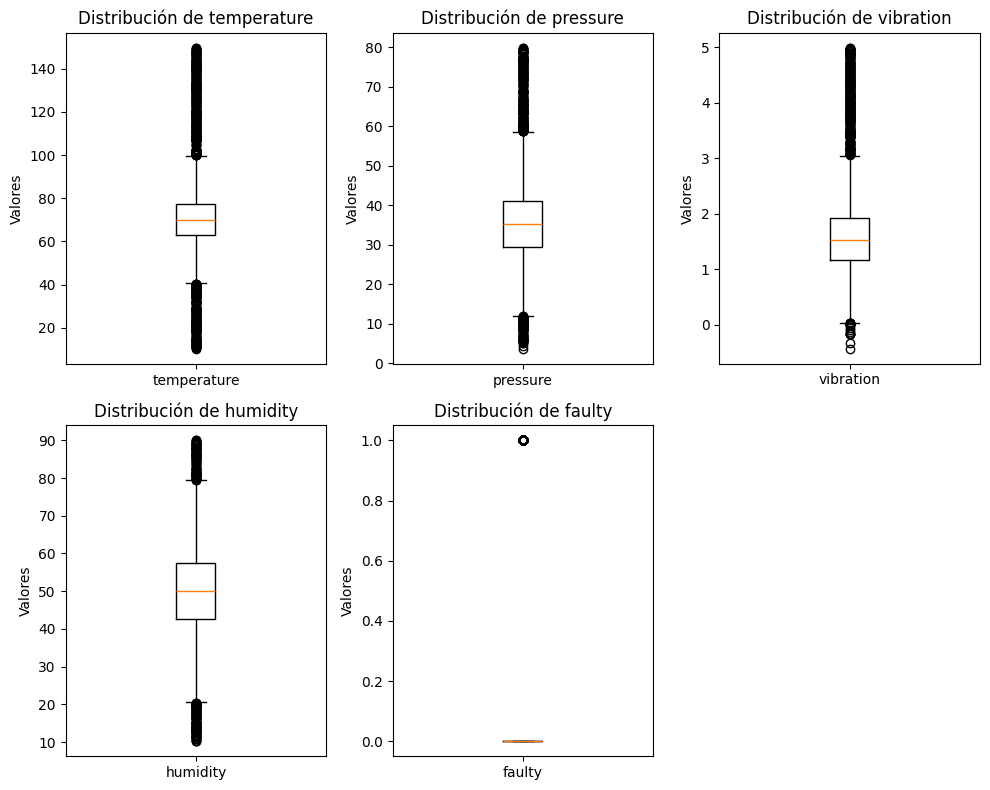

In [116]:
#Visualizamos solo los de tipo Float
categorias = ['temperature', 'pressure','vibration','humidity','faulty'] 
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 8))

axes = axes.flatten() 
for i, var in enumerate(categorias): 
    axes[i].boxplot(datos[var], tick_labels=[var]) 
    axes[i].set_title(f'Distribución de {var}') 
    axes[i].set_ylabel('Valores')
    
for j in range(len(categorias), len(axes)): 
    axes[j].axis('off')

plt.tight_layout() 
plt.show()

Como podemos ver, parece que tenemos diferentes outliers por lo que usaremos un gráfico de barras para visualizar los datos mejor

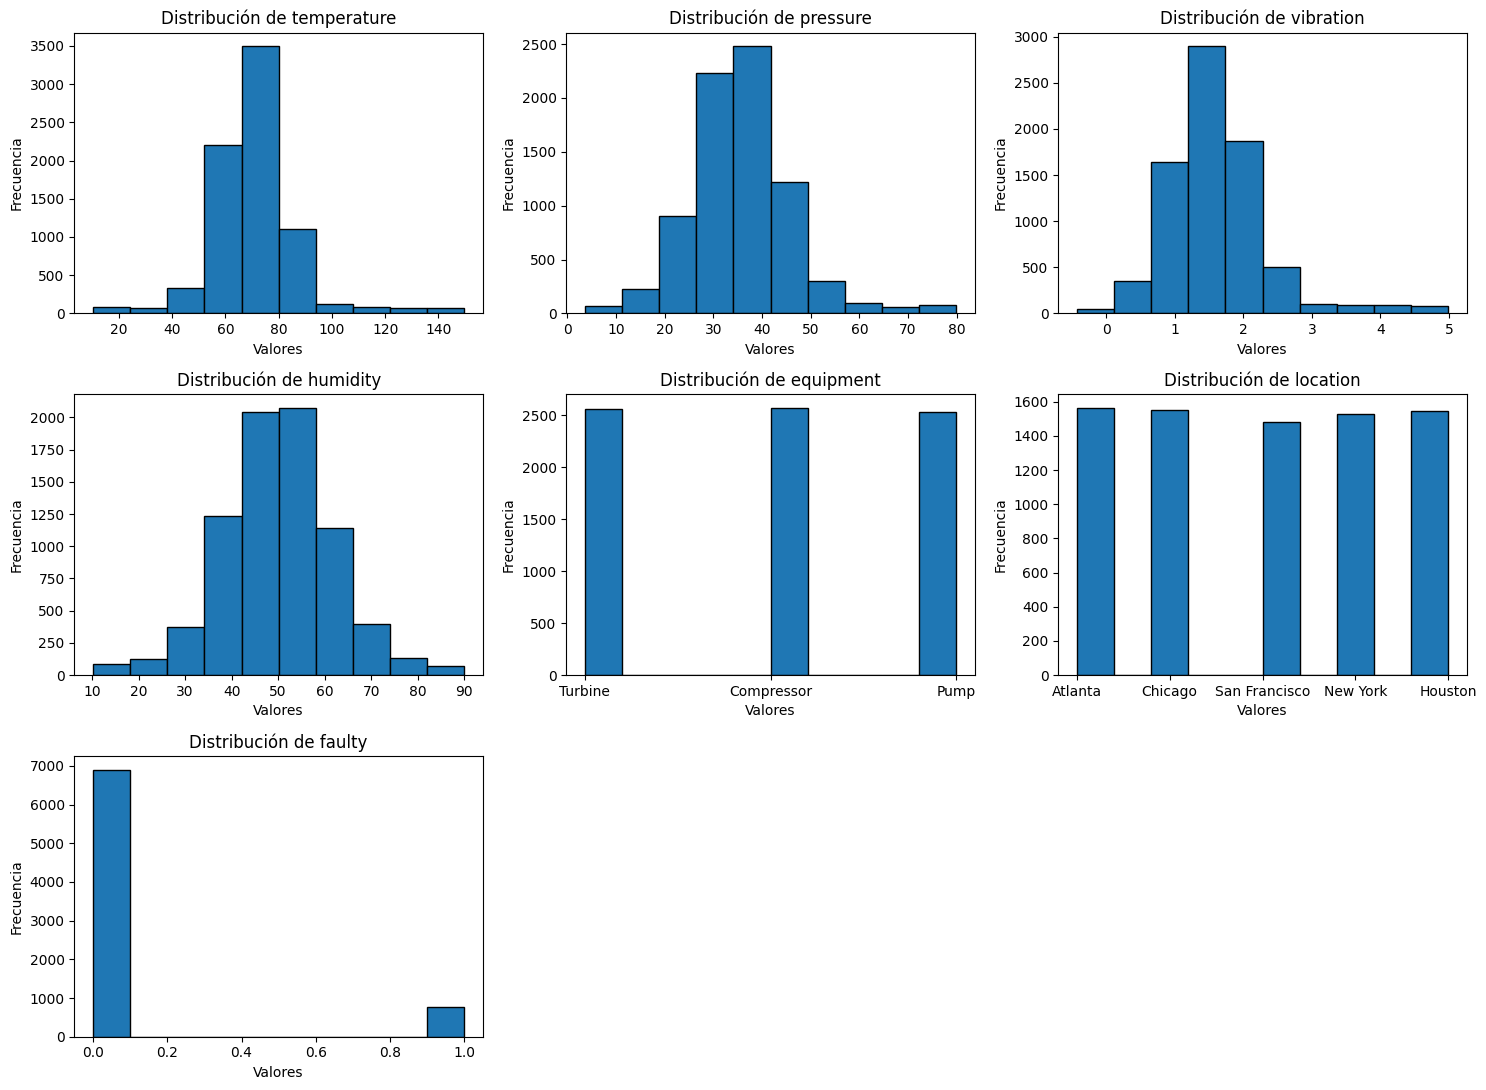

In [117]:
categorias = ['temperature','pressure','vibration','humidity','equipment','location','faulty']  # No es necesario que sea una lista
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 11)) 

axes = axes.flatten()

for i, var in enumerate(categorias):
    axes[i].hist(datos[var], edgecolor='black')
    axes[i].set_title(f'Distribución de {var}')
    axes[i].set_xlabel('Valores')
    axes[i].set_ylabel('Frecuencia')

    for j in range(len(categorias), len(axes)):
        axes[j].axis('off')

plt.tight_layout()
plt.show()


Analizaremos los no numéricos

In [118]:
datos['equipment'].value_counts()


equipment
Compressor    2573
Turbine       2565
Pump          2534
Name: count, dtype: int64

In [119]:
datos['location'].value_counts()

location
Atlanta          1564
Chicago          1553
Houston          1548
New York         1526
San Francisco    1481
Name: count, dtype: int64

In [120]:
datos['faulty'].value_counts()

faulty
0.0    6905
1.0     767
Name: count, dtype: int64

Una vez comprobados vemos que por un lado **faulty** tiene demasiados defectuosos en comparación a los buenos y **location** y **equipment** hay que pasarlos a valores numéricos ya que son de tipo **object**

### Ingeniería de Características

Usaremos el OneHot Encoder ya que se ajusta más a lo que necesitamos

No usamos LabelEncoder porque en location por ejemplo las ciudades no tienen un orden lógico entre ellas, por lo que no tiene sentido. Y en equipment lo mismo

In [121]:
#OneHot Encoder de 'location' y 'equipment'
encoder = OneHotEncoder(sparse_output=False)

#Aplicamos encoder a las columnas categóricas (no numéricas)
categoricas = ['location','equipment']
valores = encoder.fit_transform(datos[categoricas])

#Crear el dataframe con las nuevas columnas (codificadas)
nuevas_columnas = encoder.get_feature_names_out(categoricas)
datos_encoded = pd.DataFrame(valores, columns=nuevas_columnas, index=datos.index)

datos = pd.concat([datos, datos_encoded], axis=1).drop(categoricas, axis=1)


In [122]:
#Comprobamos los datos de nuevo para ver si se ha aplicado correctamente
datos.head()

,temperature,pressure,vibration,humidity,faulty,location_Atlanta,location_Chicago,location_Houston,location_New York,location_San Francisco,equipment_Compressor,equipment_Pump,equipment_Turbine
0,58.180180,25.029278,0.606516,45.694907,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,75.740712,22.954018,2.338095,41.867407,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,71.358594,27.276830,1.389198,58.954409,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,71.616985,32.242921,1.770690,40.565138,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,66.506832,45.197471,0.345398,43.253795,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


Ahora una vez tenemos las columnas **Equipment** y **location** en numéricas nos encargaremos de los outliers, a falta de balancear la columna **faulty** que recordemos, tenía muchos datos defectuosos en comparación a los buenos

#### Eliminación de Outliers

Si lo que queremos es eliminar los outliers con la técnica del IQR deberemos tener en cuenta que se calculan con la diferencia entre el cuartil 75 y el 23 (Q1 y Q3)

Procederemos con **temperature** **vibration** **pressure** y **humidity**

In [123]:
#Seleccionar las columnas numéricas (puedes especificar las que quieras)
numerical_columns = ['temperature', 'pressure', 'vibration', 'humidity']

#Eliminar outliers con un array (también se podrían hacer uno a uno)
for col in numerical_columns:
    # Calcular Q1, Q3 y el IQR
    Q1 = np.percentile(datos[col], 25)
    Q3 = np.percentile(datos[col], 75)
    IQR = Q3 - Q1
    
    #Calcular los límites superior e inferior
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    #Filtrar los outliers y mantener solo los valores dentro de los límites
    datos = datos[(datos[col] >= lower_bound) & (datos[col] <= upper_bound)]

#Verificamos que se han eliminado los outliers
datos.describe()


,temperature,pressure,vibration,humidity,faulty,location_Atlanta,location_Chicago,location_Houston,location_New York,location_San Francisco,equipment_Compressor,equipment_Pump,equipment_Turbine
count,6853.000000,6853.000000,6853.000000,6853.000000,6853.000000,6853.000000,6853.000000,6853.000000,6853.000000,6853.000000,6853.000000,6853.000000,6853.00000
mean,69.901442,35.080251,1.510590,50.066317,0.012549,0.205749,0.202101,0.201955,0.199621,0.190573,0.333868,0.331971,0.33416
std,10.012279,7.826196,0.496451,9.783193,0.111326,0.404278,0.401597,0.401488,0.399744,0.392782,0.471628,0.470955,0.47173
min,40.596114,13.037604,0.115814,23.097244,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,63.180158,29.732211,1.167866,43.124762,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,69.907114,35.058805,1.509059,50.039622,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,76.683405,40.434351,1.853260,56.765488,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.00000
max,99.613588,57.337671,2.919811,77.427966,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


Hemos eliminado los outliers correctamente

Ahora pasaremos a la target **fault**, la cual estaba desbalanceada y aplicaremos el balanceo correspondiente
En este caso vamos a hacer Oversampling (aumentar la clase minoritaria)

Usaremos la técnica de SMOTE

In [124]:
#Definir las características (X) y la variable objetivo (y)
X = datos.drop(columns=['faulty'])  #Las características (columnas que no son 'faulty')
y = datos['faulty']  #La target (faulty)


#Dividir en entrenamiento y prueba ANTES de aplicar SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#Ver distribución antes de aplicar SMOTE
print("Distribución antes de SMOTE:")
print(y_train.value_counts())

#Aplicar SMOTE solo en el conjunto de entrenamiento
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

#Ver distribución después de aplicar SMOTE
print("\nDistribución después de SMOTE:")
print(y_train_resampled.value_counts())


Distribución antes de SMOTE:
faulty
0.0    5413
1.0      69
Name: count, dtype: int64

Distribución después de SMOTE:
faulty
0.0    5413
1.0    5413
Name: count, dtype: int64


Después de aplicar SMOTE (resample) podemos ver que ahora sí quedan balanceadas

## Entrenamiento

Antes de comenzar a entrenar al modelo deberemos escalar el Dataframe ya que es obligatorio en las redes neuronales

#### Escalar Dataframe

In [125]:
#Escalado después de aplicar SMOTE
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)  #Aplicar la misma transformación a los datos de prueba

#### Red Neuronal Básica

In [ ]:
#Si no mejora el modelo después de 5 etapas se detendrá
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
#Red neuronal
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_resampled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')  #Salida binaria
])

#Compilar (paso posterior)
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
              
model.summary()




c:\Users\juan_\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [127]:
history = model.fit(X_train_resampled, y_train_resampled, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50
271/271 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6058 - accuracy: 0.6055 - loss: 1.0323 - val_AUC: 0.0000e+00 - val_accuracy: 0.6288 - val_loss: 0.8276
Epoch 2/50
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.8748 - accuracy: 0.8071 - loss: 0.5351 - val_AUC: 0.0000e+00 - val_accuracy: 0.9663 - val_loss: 0.2711
Epoch 3/50
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.9364 - accuracy: 0.8729 - loss: 0.3874 - val_AUC: 0.0000e+00 - val_accuracy: 0.8897 - val_loss: 0.3711
Epoch 4/50
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.9514 - accuracy: 0.8836 - loss: 0.3376 - val_AUC: 0.0000e+00 - val_accuracy: 0.9266 - val_loss: 0.2742
Epoch 5/50
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.9594 - accuracy: 0.8986 - loss: 0.3099 - val_AUC: 0.0000e+00 - val_accuracy: 0.8116 - val_loss: 0.4964
Epoch 6/50
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.9625 - accuracy: 0.9053 - loss: 0.2962 - val_AUC: 0.0000e+00 - val_accuracy: 0.9395 - val_loss: 0.2569
Epoch 7/50
271/2

Una vez realizado el entrenamiento es imprescindible visualizarlo y analizar las curvas de pérdida y de precisión, para detectar problemas como sobreajuste o subajuste

In [128]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Pérdida: {loss}, Precisión: {accuracy}")


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.5720 - accuracy: 0.9693 - loss: 0.1591   


ValueError: too many values to unpack (expected 2)

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9798 - loss: 0.1071
Pérdida: 0.14078250527381897, Precisión: 0.9686360359191895


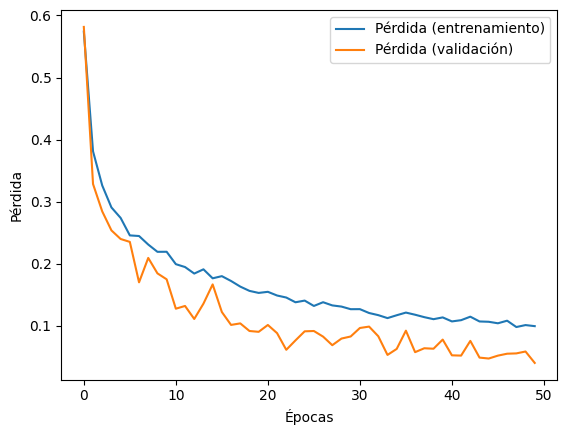

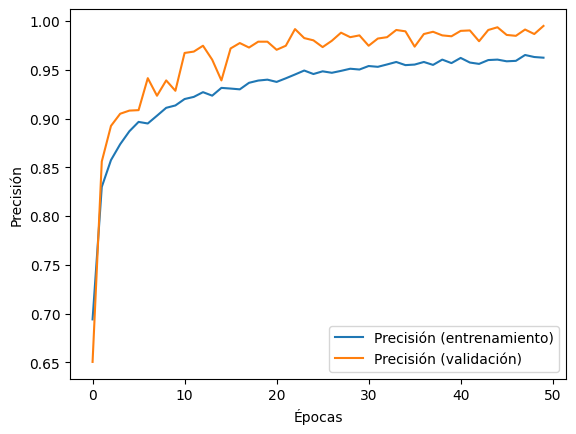

In [102]:
#Visualización de la convergencia y curvas de aprendizaje
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Pérdida: {loss}, Precisión: {accuracy}")

#Pérdida
plt.plot(history.history['loss'], label='Pérdida (entrenamiento)')
plt.plot(history.history['val_loss'], label='Pérdida (validación)')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()
#Precisión
plt.plot(history.history['accuracy'], label='Precisión (entrenamiento)')
plt.plot(history.history['val_accuracy'], label='Precisión (validación)')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

Ambas gráficas muestran como con el entrenamiento mejora pero no del todo

En la pérdida podemos ver como la pérdida es alta y disminuye con el paso de las épocas, lo que nos indica que está aprendiendo

Pero cuando va por 20 épocas podemos observar que empieza a dejar de disminuir y oscila hasta incluso aumentar. Esto nos indica un posible overfitting

El hecho de que la pérdida en validación deje de bajar e incluso llegue a subir es un claro caso de overfitting (el modelo está memorizando datos de entrenamiento en vez de aprender)

En la gráfica de precisión podemos ver como en el entrenamiento aumenta y queda estable hasta que comienza con fluctuaciones

La validación queda estable y no mejora, lo cual también podría indicar overfitting porque no está mejorando su capacidad de generalización a nuevos datos, aunque es posible que estando cerca del 0.989 esté ya al máximo rendimiento



43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


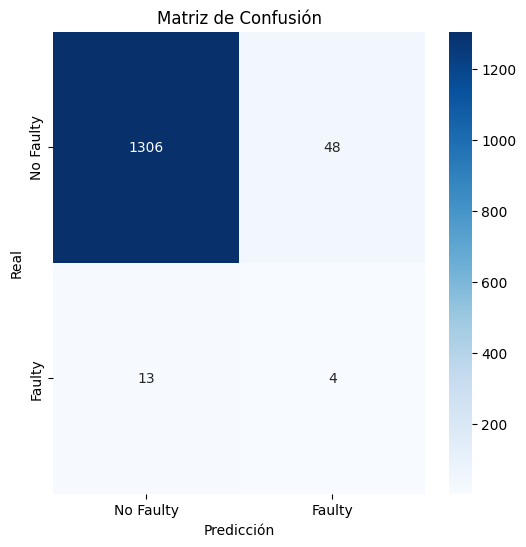


Classification Report:
              precision    recall  f1-score   support

   No Faulty       0.99      0.96      0.98      1354
      Faulty       0.08      0.24      0.12        17

    accuracy                           0.96      1371
   macro avg       0.53      0.60      0.55      1371
weighted avg       0.98      0.96      0.97      1371



In [129]:
y_pred = model.predict(X_test)  #Predicciones (probabilidades)
y_pred = np.round(y_pred).astype(int)  #Convertir probabilidades a clases (0 o 1)

# 2. Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Faulty', 'Faulty'], 
            yticklabels=['No Faulty', 'Faulty'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

# 3. Métricas adicionales
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Faulty', 'Faulty']))

# 4. Métricas individuales
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)


El modelo tiene un buen rendimiento en la clase mayoritaría **No defectuoso** pero en la clase minoritaria no

Se aprecia un desbalanceo incluso habiendo hecho SMOTE
(Muestra un claro ejemplo de desbalanceo)





In [104]:
# Ver distribución de clases en el conjunto de entrenamiento
print(y_train_resampled.value_counts())


faulty
0.0    5413
1.0    5413
Name: count, dtype: int64


In [105]:
from sklearn.utils.class_weight import compute_class_weight

# Calcular el peso de las clases basado en los datos
class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_train_resampled)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# Entrenar el modelo con los pesos de las clases
history = model.fit(X_train_resampled, y_train_resampled, 
                    epochs=50, batch_size=32, 
                    validation_split=0.2, verbose=1,
                    class_weight=class_weight_dict,
                    callbacks=[early_stopping])  # Agregar early stopping


Epoch 1/50
271/271 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9669 - loss: 0.0984 - val_accuracy: 0.9848 - val_loss: 0.0522
Epoch 2/50
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9647 - loss: 0.0982 - val_accuracy: 0.9963 - val_loss: 0.0337
Epoch 3/50
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9584 - loss: 0.1019 - val_accuracy: 0.9977 - val_loss: 0.0377
Epoch 4/50
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9633 - loss: 0.0980 - val_accuracy: 0.9949 - val_loss: 0.0437
Epoch 5/50
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9615 - loss: 0.1050 - val_accuracy: 0.9931 - val_loss: 0.0436
Epoch 6/50
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9581 - loss: 0.1021 - val_accuracy: 0.9922 - val_loss: 0.0451
Epoch 7/50
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9647 - loss: 0.0951 - val_accuracy: 0.9963 - val_loss: 0.0319
Epoch 8/50
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9653 - loss: 0.0959 - val_accuracy: 0.

In [106]:
y_pred = (model.predict(X_test) > 0.3).astype(int)  # Usar un umbral de 0.3 en vez de 0.5


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [107]:
# Calcular AUC-ROC
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, y_pred)
print(f'AUC-ROC: {roc_auc}')


AUC-ROC: 0.5756799026848554


In [108]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras_tuner import RandomSearch
import tensorflow as tf
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Función para crear el modelo
def build_model(hp):
    model = Sequential([
        Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='relu'),
        Dense(1, activation='sigmoid')  # Salida para clasificación binaria
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.01])),
                  loss='binary_crossentropy', metrics=['accuracy'])  # Cambio aquí
    return model

#Crear el tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    directory='./',
    project_name='prediccion'
)

# Dividir en entrenamiento y validación
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Usar SMOTE para balancear las clases
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_split, y_train_split)

# Buscar los mejores hiperparámetros
tuner.search(X_resampled, y_resampled, validation_data=(X_val, y_val), epochs=50, batch_size=32)

# Obtener los mejores hiperparámetros
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Construir el mejor modelo
best_model = tuner.hypermodel.build(best_hps)

# Entrenar el modelo con los mejores hiperparámetros
history = best_model.fit(X_resampled, y_resampled, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])


FailedPreconditionError: . is not a directory